In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

In [30]:
heldout = [0.95, 0.90, 0.75, 0.50, 0.25, 0.1, 0.01]
rounds = 100
rng = np.random.RandomState(42)

xx = 1. - np.array(heldout)

In [31]:
def estimate_error(classifier, dataset, test_size, rounds):
    yy_ = []
    for r in range(rounds):
        #print "round {}/{}".format(r+1, rounds)
        X, y = dataset.data, dataset.target
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=rng)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        #print y_pred
        yy_.append(1 - np.mean(y_pred == y_test))
    return np.mean(yy_)

In [32]:
def compare_classifiers_on_dataset(classifiers, dataset, dataset_name):
    for name, clf in classifiers:
        print("training %s on %s" % (name, dataset_name))
        yy = []
        for i in heldout:
            yy.append(estimate_error(clf, dataset, i, rounds))
        plt.plot(xx, yy, linestyle='--', dashes=np.random.randint(5, 10, size=6), label=name)
    
    plt.legend(title=dataset_name, loc="upper right")
    plt.xlabel("Proportion train")
    plt.ylabel("Test Error Rate")
    plt.show()

In [33]:
iris = datasets.load_iris()
digits = datasets.load_digits()

test_datasets = [
    ("Iris", iris),
    ("Digits", digits)
]

In [54]:
class WidrowHoffClassifier():
    def __init__(self, rate_exp = 4, n_iter_10 = 3):
        # params are "simplified" for easier use with hyperopt
        self.rate_exp = rate_exp
        self.rate = 10 ** (-1*rate_exp)
        self.n_iter_10 = n_iter_10
        self.n_iter = int(n_iter_10*10)

    def fit(self, X, y):
        self.weight = np.zeros(1 + X.shape[1])
        self.errors = []
        self.cost = []
        for i in range(self.n_iter):
            output = self.decision_function(X)
            errors = y - output
            self.weight[1:] += self.rate * X.T.dot(errors)
            self.weight[0] += self.rate * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost.append(cost)
        return self

    def decision_function(self, X):
        return np.dot(X, self.weight[1:]) + self.weight[0]

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0.0, 1, -1)
    
    def get_params(self, deep=True):
        return {"rate_exp": self.rate_exp, "n_iter_10": self.n_iter_10}

In [55]:
############################################################################################################
# sklearn offers "OneVsRest", but it only works on sklearn estimators [require more function than we have implemented for Widrow-Hoff].
# we compared the two on various classifiers, they both give the same exact classifications... :)
############################################################################################################
class BinaryToOneVsAllAdapter():
    def __init__(self, binary_classifier):
        self.original_classifier = binary_classifier
        
    def fit(self, X, y):
        from sklearn.base import clone
        self.class_type = y.dtype
        Y = pd.Series(y).astype("string").str.get_dummies().replace(0,-1)
        # get a dictionary of Class => Binary classifier
        self.binary_classifier_per_class = {}
        for cls in Y.columns:
            new_classifier = clone(self.original_classifier)
            new_classifier.fit(X, Y[cls])
            self.binary_classifier_per_class[cls] = new_classifier
    
    def predict(self, X):
        def make_decision_function_for_sample(sample):
            return lambda cls: self.binary_classifier_per_class[cls].decision_function([sample])
        return np.asarray([max(self.binary_classifier_per_class, key=make_decision_function_for_sample(sample)) for sample in X], self.class_type)

In [56]:
##################################################################################
# This code takes time to run, it finds optimal arguments for the classifiers.
# We hardcoded the result of the run to avoid the runtime cost.
##################################################################################
#def hyperopt_objective(args):
#    rate_exp, n_iter_10 = args
#    clf = BinaryToOneVsAllAdapter(WidrowHoffClassifier(rate_exp, n_iter_10))
#    return estimate_error(clf, iris, 0.2, 20)
    
#from hyperopt import fmin, tpe, hp
#space = (hp.uniform('rate_exp', 1, 6), hp.uniform('n_iter_10', 1, 6))
#best = fmin(hyperopt_objective, space, algo=tpe.suggest, max_evals=100)

best = {'n_iter_10': 3.203077885680808, 'rate_exp': 4.154778813173185}

In [57]:
classifiers = [
    ("Widrow-Hoff", BinaryToOneVsAllAdapter(WidrowHoffClassifier(best['rate_exp'], best['n_iter_10']))),
    # sklearn's Perceptron has a built-in OvA implemented for multiclass targets
    ("Perceptron", Perceptron())
]

training Widrow-Hoff on Iris
training Perceptron on Iris


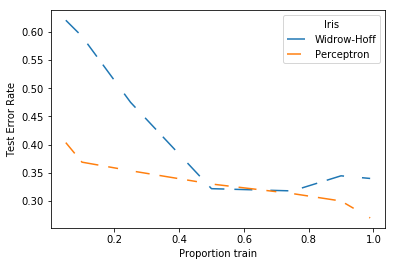

training Widrow-Hoff on Digits
training Perceptron on Digits


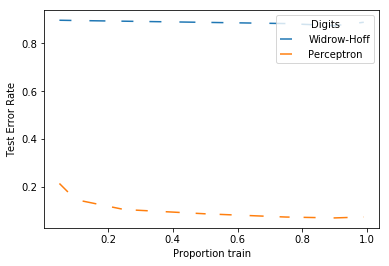

In [58]:
for dataset_name, dataset in test_datasets:
    compare_classifiers_on_dataset(classifiers, dataset, dataset_name)

# Convergance Corner Cases
We shall try and make evil yet simple datasets,
that are easily fitted by one model but the other hardly converges on them.
## "Black-White image with single relevant pixel"
Let's start off with samples that have 16 features, that can be thought of as a 4x4 map of pixels.
We will prepare a data set for which every sample's label is identical to its (1,1) pixel [that's element 5].
It means that in a successfully fitted model the weight of this pixel needs to dominate the sum of weights of all the others

In [21]:
from collections import namedtuple
Dataset = namedtuple('Dataset', ['data', 'target'])

In [22]:
my_set_features = np.array([np.array([float(c) for c in '{0:016b}'.format(i)]) for i in range(2**16)])
my_set_features

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [23]:
my_set_features[my_set_features==0.0] = -1.0
my_set_features

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ..., -1.,  1., -1.],
       ..., 
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [24]:
my_set_labels = my_set_features[:,5]
my_set_labels

array([-1., -1., -1., ...,  1.,  1.,  1.])

training Widrow-Hoff on Pixel(1,1)
training Perceptron on Pixel(1,1)


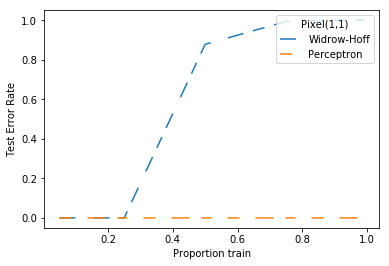

In [25]:
compare_classifiers_on_dataset(classifiers, Dataset(my_set_features, my_set_labels), "Pixel(1,1)")

## "The 4 lines"
Using the proof of the convergance theorem of perceptrons, we can make a dataset that will slow the convergance significantly.

The theorem says that converagnce will take O(R^2/gamma^2), where:
* R = the maximum "length" of any feature vector
* gamma = the "buffer" zone between positive and negative spaces on the plane

So we need an input that has many "far-away points" (to maximize R), but also very close groups of samples where one is positive and the other is negative.

we can imagine a set of samples having only 4 X-values, as 4 lines: the 2 outermost are just very far, and the 2 innermost are as close as possible to X=0, which is the exact separator of the concept we wish to learn

We don't want only one feature to be relevant, so this entire set will be "rotated" 45 degrees.

In [26]:
samples_per_line = 10000
far_x = 1e4
near_x = 1e-4
line_pos_far = np.array([(far_x, y) for y in sp.r_[-far_x: far_x: 1j*samples_per_line]])
line_neg_far = np.array([(-far_x, y) for y in sp.r_[-far_x: far_x: 1j*samples_per_line]])
line_pos_near = np.array([(near_x, y) for y in sp.r_[-far_x: far_x: 1j*samples_per_line]])
line_neg_near = np.array([(-near_x, y) for y in sp.r_[-far_x: far_x: 1j*samples_per_line]])
my_set_features2 = np.concatenate((line_pos_far, line_neg_far, line_pos_near, line_neg_near))
my_set_features2

array([[  1.00000000e+04,  -1.00000000e+04],
       [  1.00000000e+04,  -9.99799980e+03],
       [  1.00000000e+04,  -9.99599960e+03],
       ..., 
       [ -1.00000000e-04,   9.99599960e+03],
       [ -1.00000000e-04,   9.99799980e+03],
       [ -1.00000000e-04,   1.00000000e+04]])

In [27]:
my_set_labels2 = np.sign(my_set_features2[:,0])
my_set_labels2

array([ 1.,  1.,  1., ..., -1., -1., -1.])

training Widrow-Hoff on The 4 Lines
training Perceptron on The 4 Lines


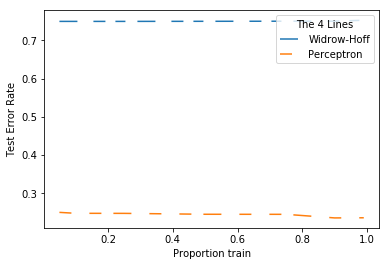

In [28]:
compare_classifiers_on_dataset(classifiers, Dataset(my_set_features2, my_set_labels2), "The 4 Lines")